# First Glance at QKAN and DARUAN

Quantum-inspired Kolmogorov-Arnold Network (QKAN) is a novel approach to integrate the concept of Quantum Variational Activation Function (QVAF) into KANs.
We use single qubit data reuploading circuit as a quantum-inspired activation function, DatA Re-Uploading ActivatioN (DARUAN), to enhance the expressivity of KANs.

## DatA Re-Uploading ActivatioN (DARUAN)

![DARUAN](../fig/daruan.png)

While the word **daruan** may evoke the traditional Chinese string instrument, in our context, **DARUAN** refers to a **quantum-inspired activation function** derived from the concept of **data re-uploading circuits**.

DARUAN leverages the architecture of data re-uploading to build a scalable and expressive **quantum variational activation layer**. Each block consists of fixed data encoding interleaved with **trainable unitaries**, forming a variational circuit capable of approximating both smooth **periodic** and **non-periodic** functions.

The circuit outputs the **expectation value of a Pauli observable** (typically $\sigma_z$), which is used as the **nonlinear transformation** (activation) applied to the neuron's input.

In the figure below, DARUAN acts as a variational activation function (VAF) within a perceptron. Classical data is re-uploaded multiple times into the quantum circuit, and the final output is obtained via measurement:

![DARUAN in Perceptron](../fig/DARUAN-perceptron.png)

### Layer Extension Mechanism

A key feature of DARUAN is its architectural **flexibility** through what we call **layer extension**—a mechanism that progressively increases the number of re-uploading repetitions (or depth of the variational circuit). This enables the model to:

- Scale its expressivity on demand
- Retain and refine previously learned features
- Avoid catastrophic forgetting during deeper training

### Practical Advantages

- **Hardware-efficient**: Implemented using only single-qubit rotations and measurements
- **NISQ-compatible**: Suitable for near-term quantum devices
- **Expressive**: Capable of approximating a wide class of functions with minimal depth

> DARUAN demonstrates that simple quantum-inspired modules can serve as powerful building blocks for classical or hybrid neural networks, bridging ideas from variational quantum algorithms and modern machine learning.

## Quantum-Inspired Kolmogorov–Arnold Networks (QKAN)

Building upon the foundational ideas of **Kolmogorov–Arnold Networks (KANs)** and the expressive capacity of the **DARUAN** activation function, we introduce the **Quantum-Inspired Kolmogorov–Arnold Network (QKAN)**.

In QKAN, the traditional B-spline-based activation functions used in KAN are replaced by single-qubit **data re-uploading variational quantum circuits** (DARUAN), providing a compact and highly trainable nonlinear transformation.

---

### Motivation and Principle

The key insight of QKAN is to leverage the **Fourier-like expansion behavior** of quantum data re-uploading circuits, which approximate target functions through tunable superpositions of sinusoidal frequency components.

While classical KANs express nonlinearities using B-spline basis functions (requiring a grid size $G$), QKAN approximates similar functional forms by estimating Fourier coefficients through a **parameter-efficient quantum circuit** with only a small number of re-uploading repetitions $r$.

This makes QKAN especially attractive in settings where parameter and memory efficiency are critical.

---

### Architecture

![QKAN Architecture](../fig/qkan.png)

Each layer in QKAN is a feedforward structure composed of **independent DARUAN modules**. For a layer $\ell$ with $n_\ell$ input nodes and $n_{\ell+1}$ output nodes, the layer is defined as:

$$
\begin{align}
  &\Phi_\ell = \{\phi_{\ell,j,i}\}, \quad i = 1,\dots,n_\ell; \quad j = 1,\dots,n_{\ell+1} \\
  &\phi_{\ell,j,i}(x_{\ell,i}) = \langle 0 \vert U(x_{\ell,i}, \boldsymbol{\theta}_{\ell,j,i})^\dagger M U(x_{\ell,i}, \boldsymbol{\theta}_{\ell,j,i}) \vert 0 \rangle \\
  &x_{\ell+1,j} = \sum_{i=1}^{n_\ell} \phi_{\ell,j,i}(x_{\ell,i})
\end{align}
$$

Here:
- $U(x; \boldsymbol{\theta})$ is a **data re-uploading unitary** parameterized by $\boldsymbol{\theta}$,
- $M$ is the **Pauli observable** (e.g., $\sigma_z$) used for measurement,
- Each $\phi_{\ell,j,i}$ acts as a nonlinear activation between nodes $i$ and $j$.

The full QKAN model is then composed by sequentially stacking these layers:

$$
\boldsymbol{y} = \text{QKAN}(\boldsymbol{x}) = \left( \Phi_L \circ \Phi_{L-1} \circ \cdots \circ \Phi_1 \right)(\boldsymbol{x})
$$

Because each quantum expectation value lies in the range $[-1, 1]$, the output at layer $\ell+1$ is bounded within:

$$
x_{\ell+1,j} \in [-n_\ell, n_\ell]
$$

To extend the bounded output to a desired range, some post activation transformation (e.g., FCN or linear weight/bias layer) can be applied.

---

QKAN introduces a quantum-inspired activation mechanism into a Kolmogorov–Arnold framework, leading to:

- High **expressive power** through tunable quantum feature maps
- Strong **parameter efficiency** compared to B-spline KANs
- Seamless integration with both classical and hybrid neural architectures

> QKAN merges insights from function approximation theory, Fourier analysis, and quantum variational circuits, offering a promising path forward for expressive, scalable, and hardware-efficient learning models.

## Example: Training a QKAN Model for Function Approximation

This section provides a minimal example of how to **train a QKAN model** using the **DARUAN activation function**, and how to **visualize the learned nonlinearities**.

100%|█████████████| 20/20 [00:04<00:00,  4.42it/s, train loss=2.7591048e-05, test loss=2.865495e-05]


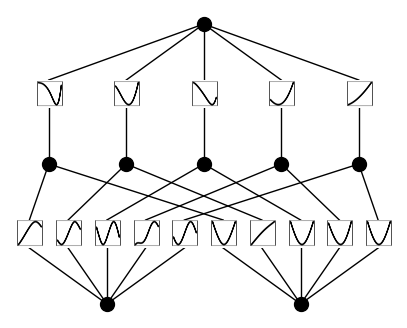

In [1]:
import torch

from qkan import QKAN, create_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

# f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)

model = QKAN(
    [2,5,1],
    reps = 3,
    device=device,
    preact_trainable=True, # enable flexible fourier frequency
    postact_bias_trainable=True, # extend output bound
    postact_weight_trainable=True, # extend output bound
    ba_trainable=True, # enable residual connection for better convergence
    save_act=True, # save activation for visualization
)
optimizer = torch.optim.LBFGS(model.parameters(), lr=1.)

model.train_(dataset, optimizer=optimizer, steps=20)
model.plot(from_acts=True, metric=None)

We also demonstrate how to apply **pruning**, a technique originally proposed in the KAN paper, to reduce the number of active nodes and simplify the model without sacrificing performance.

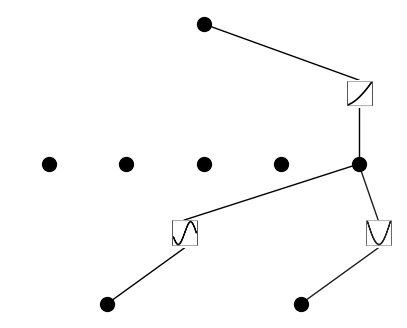

In [2]:
model.prune(node_th=0.5)
model.plot(dataset["train_input"], mask=True)

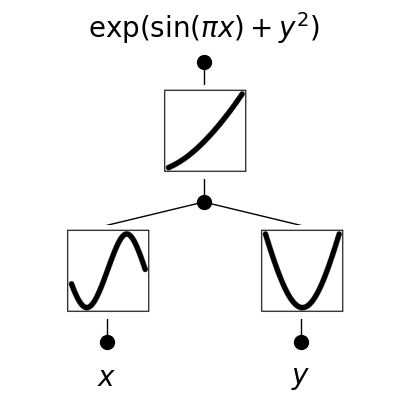

In [3]:
new_model = model.prune(node_th=0.5)
new_model(dataset['train_input'])
new_model.plot(from_acts=True, metric=None, in_vars=["$x$", "$y$"], out_vars=["$\exp(\sin(\pi x)+y^2)$"])

From the trained activation plots, we can infer the underlying structure of the learned function. In this example, the QKAN model, with minimal architecture, successfully recovers the form of the target function $f(x,y) = \exp(\sin(\pi x)+y^2)$.

## Further Reading

If you are interested in learning more about QKAN and DARUAN, please read our paper: **["Quantum Variational Activation Functions Empower Kolmogorov-Arnold Networks"](https://arxiv.org/abs/2509.14026)**.